### Libraries & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn  import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

random_state=42

##  Dataset

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
# get categorical data
categorical_features = df.select_dtypes(include=['object'])
#categorical_features

In [4]:
# get numerical data
Numeric_data = df.select_dtypes(include='number')
#Numeric_data

- Isolate the features and the target values.

- The target variable(y) is the last column in the Data Frame and hence using slicing, can separate them into feature and label.

In [5]:
# get all categorical feature except target vale y(deposit)
feature = categorical_features.iloc[:,:-1].values

In [6]:
label = categorical_features.iloc[:,-1].values
#label

### Correlation Matrix of the Numerical Features:

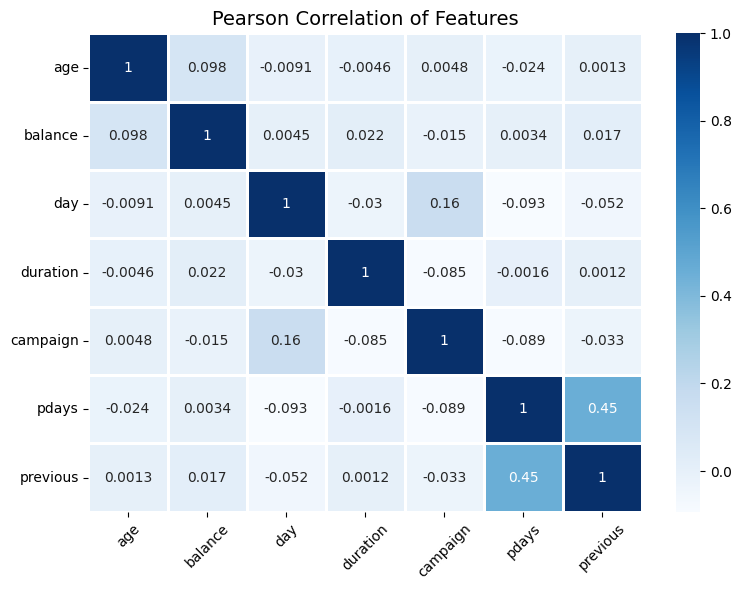

In [7]:
corr = df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), cmap='Blues', annot=True, square=False, linewidth=1, xticklabels=corr.columns, yticklabels=corr.columns, annot_kws={"size": 10}, ax=ax)
ax.set_title('Pearson Correlation of Features', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
fig.tight_layout()


**Observation**

- it seems **no** feature is heavily correlated with other features

## Imbalanced target value

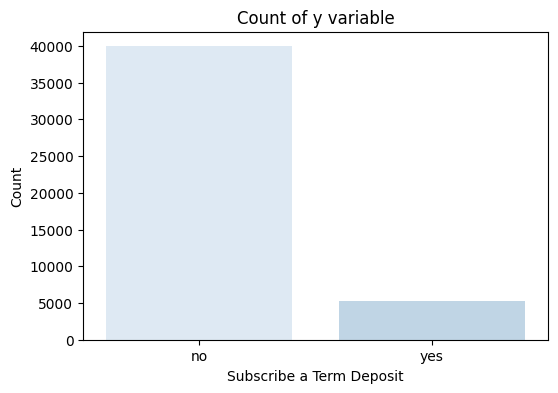

In [8]:
# set the color palette
sns.set_palette("Blues")

# plot the countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title("Count of y variable")
plt.xlabel("Subscribe a Term Deposit")
plt.ylabel("Count")
plt.show()

#  Pre_processing

### Drop Unnecessary Columns 

In [9]:
# According to EDA, some features like day,month have no affect on subscribition

df.drop(['day', 'month','duration'], axis=1, inplace=True) # 

- There are no missing values in this dataset. However, there are values labeled as unknown, which can be considered similar to missing values.



- The unknown values for the job and education columns are randomly distributed throughout those columns, indicating that they were not recorded or were otherwise unavailable. In this case, we may want to consider treating these unknown values as missing and imputing them using a suitable imputation method.



- The unknown values for the poutcome column represent the outcome of the previous marketing campaign for customers who were not previously contacted. To handle these values, we could segment the entire column into two categories: success and not success, based on whether the previous marketing campaign was successful or not. This would allow us to retain the information in the poutcome column without introducing missing values into the dataset.

    
- Overall, it is important to carefully consider the treatment of unknown values and missing values in the dataset to ensure that they do not bias the analysis or lead to inaccurate conclusions.

### Impute the Unknown Values

In [10]:
# Define the list of columns to impute
columns_to_impute = ['job', 'education']


# Loop over each column and impute unknown value
for i in columns_to_impute:
    # Compute the normalized value counts for non-unknown values
    value_counts = df.loc[df[i] != 'unknown', i].value_counts(normalize=True)
    df.loc[df[i] == 'unknown', i] = np.random.choice(value_counts.index, 
                                                       p = value_counts.values, size = df.loc[df[i]  == 'unknown'].shape[0] )

In [11]:
# 'unknown', 'failure', and 'other' indicate a lack of success in the previous marketing campaign
# We are replacing these values with 'not success' to simplify the analysis
# Note that the 'success' values are retained as-is
df['poutcome'] = df['poutcome'].replace({'unknown':'not success', 'failure':'not success', 'other':'not success'})

# Check the unique values in the original column
print(df['poutcome'].unique())


['not success' 'success']


### Log Transformation on outliers

- we have several features with outliers and skewness


- As the outliers can  impact on the performance of ML models. I apply log transformation on some of them 


- I dont transfrom those features that are naturally skewed  like age,balance. 


In [12]:
#  age, balance, duration, compaign, pdays and previous has some outliers need to take a log

#df['campaign'] = np.log10(df['campaign'] + 1)
#df['previous'] = np.log10(df['previous'] + 1)
#df['pdays'] =    np.log10(df['pdays'] + 1)

# Transforem some Columns

In [13]:
#Rename the target variable column and define new columns for deposit yes and no
#This will make it easier to analyze the data
df = df.rename(columns={'y': 'deposit'})
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

#Change the unit of 'duration' from seconds to minutes
#This will make the duration values easier to understand
#Note that this is a rounding operation, which might not be appropriate in all cases
#df['duration'] = df['duration'].apply(lambda n: n / 60).round(2)

## Resampling

#create two different dataframes for majority and minority class 
class_counts = df['deposit'].value_counts()

df_majority = df[df['deposit'] == class_counts.index[0]]
df_minority = df[df['deposit'] == class_counts.index[1]]

#calculate the number of samples needed to make the minority class equal to 25% of the majority class
minority_samples = int(0.25 * len(df_majority))

#upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=minority_samples, # to match 25% of majority class
                                 random_state=42)  # reproducible results

#Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled, df_majority])

In [14]:
#df['deposit'].value_counts()

In [15]:
df.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
campaign     False
pdays        False
previous     False
poutcome     False
deposit      False
dtype: bool

# Encoding

-  According to litreature in the case of imbalanced data, using label encoding could result in an unintended bias towards the majority class. 


- This is because the numerical values assigned to each category may cause the model to treat the majority class as more important than the minority class. On the other hand, using dummy encoding could result in a more balanced representation of the categories, but it may also increase the risk of overfitting to the minority class.


-  However, I try both methods and  got slightly better results on dummy than label encoding.

### Dummy Encoding the Categorical Feature

In [16]:
#Convert categorical variables to dummy variables
df_dummy = pd.get_dummies(df[['job', 'marital', 'education', 'poutcome', 'contact']])

#First Convert the object to Boolean
df['housing'] = df['housing'].astype(bool)
df['loan'] = df['loan'].astype(bool)
df['default'] = df['default'].astype(bool)

#Convert Boolean variables to integers
df['housing'] = df['housing'].astype('int')
df['loan'] = df['loan'].astype('int')
df['default'] = df['default'].astype('int')

#Drop original columns
df = df.drop(['job', 'marital', 'education', 'poutcome', 'contact'], axis=1)

#Check the first few rows of the new DataFrame
df.head()


,age,default,balance,housing,loan,campaign,pdays,previous,deposit
0,58,1,2143,1,1,1,-1,0,0
1,44,1,29,1,1,1,-1,0,0
2,33,1,2,1,1,1,-1,0,0
3,47,1,1506,1,1,1,-1,0,0
4,33,1,1,1,1,1,-1,0,0


- check another encoding methos to see if it can affect on the modeling results

### Encode the Categorical Feture by Label Encoding

#Define the columns to be label encoded
cols_to_encode = ['job', 'marital', 'education', 'poutcome', 'contact']

#Perform label encoding on each column
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#Create a LabelEncoder object
le = LabelEncoder()

#Encode 'housing', 'loan', and 'default'
df['housing'] = le.fit_transform(df['housing'].astype(str))
df['loan'] = le.fit_transform(df['loan'].astype(str))
df['default'] = le.fit_transform(df['default'].astype(str))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       45211 non-null  int64
 1   default   45211 non-null  int32
 2   balance   45211 non-null  int64
 3   housing   45211 non-null  int32
 4   loan      45211 non-null  int32
 5   campaign  45211 non-null  int64
 6   pdays     45211 non-null  int64
 7   previous  45211 non-null  int64
 8   deposit   45211 non-null  int64
dtypes: int32(3), int64(6)
memory usage: 2.6 MB


In [18]:
# Convert all columns to integer data type
#import numpy as np
#print(np.finfo(np.float128))


#df = df.astype('float')

#  Prepare the features and target variable

In [19]:
X = df.drop('deposit',axis=1)
y = df['deposit']

In [20]:
X.shape, y.shape

((45211, 8), (45211,))

# Feature Scaling

In [21]:
#Normalize the features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
columns = X.columns
X = pd.DataFrame(x_scaled, columns=columns)
#x_scaled contains the normalized features


#min max scaler
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
columns = X.columns
X = pd.DataFrame(x_scaled, columns=columns)

# Train-Test Split¶

- I set the (stratify = y)  to keep the target value ditribution unchanged

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36168, 8), (36168,), (9043, 8), (9043,))

## Cross validation - Stratified sampling 

- Cross validate to check which model performs better 


- Using **stratified** to keeping the target values distibution unchanged

In [23]:
# create a splitter object
stratified = StratifiedShuffleSplit(n_splits=5,test_size=0.2, random_state=42) 

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Define the models to compare
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state =42)

#Calculate cross-validation scores for each model
lr_cv_score = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='accuracy', cv=stratified)
knn_cv_score = cross_val_score(estimator=knn, X=X_train, y=y_train, scoring='accuracy', cv=stratified)
rf_cv_score = cross_val_score(estimator=rf, X=X_train, y=y_train, scoring='accuracy', cv=stratified)

#Print the average cross-validation score for each model
print('Logistic Regression CV Score:', lr_cv_score.mean())
print('KNN CV Score:', knn_cv_score.mean())
print('Random Forest CV Score:', rf_cv_score.mean())


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the models to compare
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

# Calculate cross-validation scores for each model
for name, model in models:
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='accuracy', cv=stratified)
    print(f'{name} CV Score:', cv_score.mean())


Logistic Regression CV Score: 0.8828310754769145
KNN CV Score: 0.8750069118053634
Random Forest CV Score: 0.8590544650262648


- we can not make a decision based on cross validation becase all the models perform quite similar



- Hence based on cross validation on the train set,  all of the three models are quite good, and does not give significant difference



- in doing the cross validation we have to sure our model is not overfitted(e.g., random forest was overfitted and we change the parameters)

# Model Building

## Logistic Regression

The target variable in this problem is "deposit", which is a binary variable with "Yes/No" values. Thus, the appropriate type of predictive models to use for developing the models are Binary Classification Algorithms.

In this project, we will be using three supervised models:

- Logistic Regression

- K-Nearest Neighbors (KNN)

- Random Forest

Each of these models is capable of learning from the data to make accurate predictions about the target variable.

In [25]:
# Fit Logistic Regression model on the training data
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = lr.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

Training accuracy: 0.8829075425790754
Test accuracy: 0.8827822625234988


In [26]:
# evaluate
confusion_matrix(y_test,test_prediction)

array([[7983,    2],
       [1058,    0]], dtype=int64)

In [27]:
# fn :model say no deposit but they actually deposit
# fp :model say deposit but they actullay NOT deposit

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7983
False positives: 2
False negatives: 1058
True positives: 0


In [28]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7985
           1       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043



# Create List for Collecting the Results

In [29]:
# two empthy list to append all the results

accu = []
methods = []

# This function is to plot the confusion matrix

In [30]:
def plot_confusion_matrix(y_test, y_pred, labels=None):
    """
    Plot a confusion matrix for the given true and predicted labels.
    Optionally, provide a list of label names to use for the plot.
    """
    if labels is None:
        labels = np.unique(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Confusion Matrix')
    plt.show()


## Hyperparameters tuning GridSearch for  Logistic Regression

- The highest class weight in this list assigns 50 times more weight to the positive class (class 1) than to the negative class (class 0). 



- This should give the model enough flexibility to find the best trade-off between precision and recall, while still accounting for the class imbalance.

In [31]:
%%time

# Define logistic regression model
lr_cv = LogisticRegression(random_state=42)


# Define the range of class_weight
#'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 50, 50)] -> better
#class_weights = [{0: 1, 1: w} for w in [1, 3, 5, 7, 10]] 

#class_freq = dict(df['deposit'].value_counts(normalize=True))
#class_weights = []
#for cls, freq in class_freq.items():
    #weight = len(df) / (len(class_freq) * freq)
    #class_weights.append({cls: weight})

class_weights = [{0: 1, 1: w} for w in [3, 5, 7, 10,12]] 

# Define hyperparameters to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],   #C': np.logspace(-3, 3, 7)
    'class_weight': class_weights,
    'solver': ['liblinear', 'saga']}


# Create GridSearchCV object
grid_search = GridSearchCV(lr_cv, param_grid, cv=stratified, scoring='f1_macro')

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Get the best estimator and score
best_lr = grid_search.best_estimator_  # best combination of hyperparameters 
best_score = grid_search.best_score_    # refers to the value of the scoring metric achieved by the best estimator.

# Evaluate the best estimator on the test data
y_pred = best_lr.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")



Best F1 score: 0.5737835359808298
Test F1 score: 0.2835365853658537
CPU times: total: 1min 39s
Wall time: 2min 13s


In [32]:
print('tuned hyperparameters: (best parameters)', grid_search.best_params_)


tuned hyperparameters: (best parameters) {'C': 0.01, 'class_weight': {0: 1, 1: 7}, 'penalty': 'l1', 'solver': 'liblinear'}


In [33]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")


Confusion matrix:
True negatives: 6791
False positives: 1194
False negatives: 686
True positives: 372


In [34]:
# appeand the test results
# Evaluate the best estimator on the test data

accu.append(best_lr.score(X_test,y_test))
methods.append('Logistic Regression')
print('X_test Accuracy:', best_lr.score(X_test,y_test))

X_test Accuracy: 0.7921043901360169


# Confusion Matrix for logistic Regression

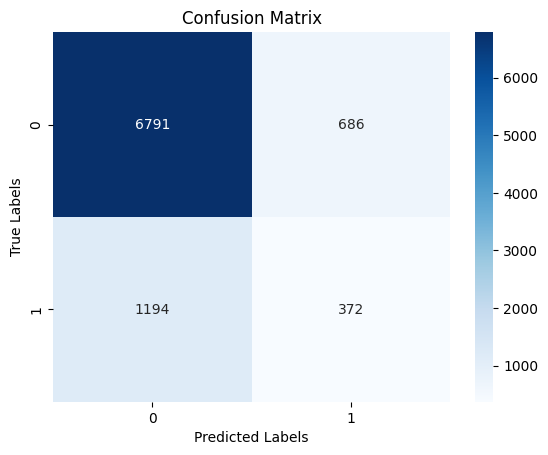

In [35]:
predictions= best_lr.predict(X_test)

plot_confusion_matrix(predictions, y_test, labels=[0, 1])

- the position of false negatives and false positives is different in the output of a general matrix in Python and a confusion matrix 

In [36]:
print(classification_report(y_test,predictions,target_names=['not deposit', 'deposit']))

              precision    recall  f1-score   support

 not deposit       0.91      0.85      0.88      7985
     deposit       0.24      0.35      0.28      1058

    accuracy                           0.79      9043
   macro avg       0.57      0.60      0.58      9043
weighted avg       0.83      0.79      0.81      9043



- Low recall means that model is struggling with classifying deposit cases

- As we try to decrease both false positive and false negative, the f1 score can be excellent metric.


- The ROC and AUC is also an intrsting metric that can show the model's effectiveness. 


- AUC closer to 1 means the model is highly effective

# K Nearest Neighbors

In [37]:
# Fit model on the training data
np.random.seed(42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = knn.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

Training accuracy: 0.8899856226498563
Test accuracy: 0.8833351763795201


In [38]:
# evaluate
confusion_matrix(y_test,test_prediction)

array([[7904,   81],
       [ 974,   84]], dtype=int64)

In [39]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7985
           1       0.51      0.08      0.14      1058

    accuracy                           0.88      9043
   macro avg       0.70      0.53      0.54      9043
weighted avg       0.85      0.88      0.84      9043



## Hyperparameters tuning GridSearch for KNN

In [40]:
%%time


# Create a k-NN classifier with class weights
knn_cv = KNeighborsClassifier(n_neighbors=10, weights='distance') # How to weight each neigbour 
                                                                  #gives more weight to close neighbour

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# classes are the unique class labels in y_train
#classes = np.unique(y_train)

# compute the class weights based on inverse of class frequency
#class_weights = compute_class_weight('balanced', classes, y_train)


# Compute class weights
#class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)


## Define hyperparameters to search over
param_grid = {'n_neighbors': [3, 5, 7, 9],
              'algorithm': ['auto'],
              'weights': ['distance', 'uniform']}

# Create GridSearchCV object
grid_search = GridSearchCV(knn_cv, param_grid, cv=stratified, scoring='f1_macro',n_jobs=-1)# f1_macro-> imbalanced data


# Fit grid search to training data
grid_search.fit(X_train, y_train)


# Get the best estimator and score
best_knn = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_knn.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

Best F1 score: 0.5674819503991422
Test F1 score: 0.1959503592423253
CPU times: total: 1 s
Wall time: 18.7 s


In [41]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Confusion matrix:")
print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

Confusion matrix:
True negatives: 7662
False positives: 323
False negatives: 908
True positives: 150


In [42]:
print('tuned hyperparameters: (best parameters)', grid_search.best_params_)

tuned hyperparameters: (best parameters) {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}


# Calculate the confusion matrix for KNN

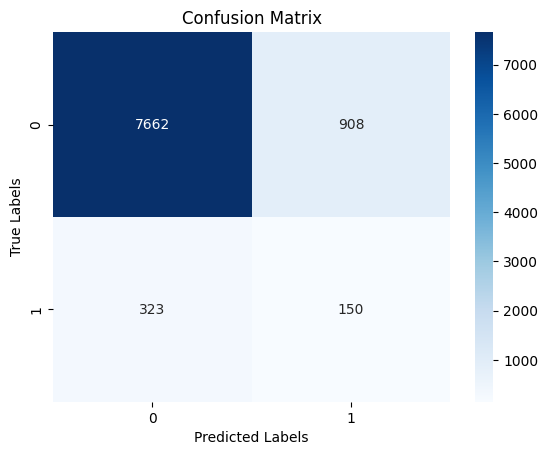

In [43]:
y_pred= best_knn.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

# KNN test Result

In [44]:
accu.append(best_knn.score(X_test,y_test))
methods.append('KNN')
print('X_test Acuracy:',best_knn.score(X_test,y_test))

X_test Acuracy: 0.8638726086475728


In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7985
           1       0.32      0.14      0.20      1058

    accuracy                           0.86      9043
   macro avg       0.61      0.55      0.56      9043
weighted avg       0.83      0.86      0.84      9043



# Random Forest

In [46]:
# Fit Random Forest model on the training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = rf.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

Training accuracy: 0.9916224286662243
Test accuracy: 0.8570164768329094


In [47]:
# evaluate
confusion_matrix(y_test,test_prediction)

array([[7607,  378],
       [ 915,  143]], dtype=int64)

In [48]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7985
           1       0.27      0.14      0.18      1058

    accuracy                           0.86      9043
   macro avg       0.58      0.54      0.55      9043
weighted avg       0.82      0.86      0.84      9043



## Hyperparameters tuning GridSearch Random Forest

In [49]:
%%time



# Define the random forest classifier 
rf_1 = RandomForestClassifier(random_state=42)


# Define the class_weight (gives equall importance to the classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Number of trees in random forest
n_estimators = [10, 30, 50, 70, 100, 120, 150],
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 7, 9]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


parameters = {'n_estimators': n_estimators , 
                  'criterion' : [ 'entropy'], 
                  'max_depth': max_depth, 
                  'max_features': ['auto','sqrt'],
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
            'class_weight':class_weights}


# Define the resampling technique (ensure the model have enough samples from the minority)
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Define the GridSearch Object
rf_cv = GridSearchCV(rf_1,parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)



# Fit grid search to training data
grid_search.fit(X_train, y_train)


# Get the best estimator and score
best_rf = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_rf.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

Best F1 score: 0.5674819503991422
Test F1 score: 0.1959503592423253
CPU times: total: 922 ms
Wall time: 9.76 s


# Random Forest test Result

In [50]:
accu.append(best_rf.score(X_test,y_test))
methods.append('Random Forest')
print('X_test Acuracy:',best_rf.score(X_test,y_test))

X_test Acuracy: 0.8638726086475728


# Confusion matrix for Random Forest

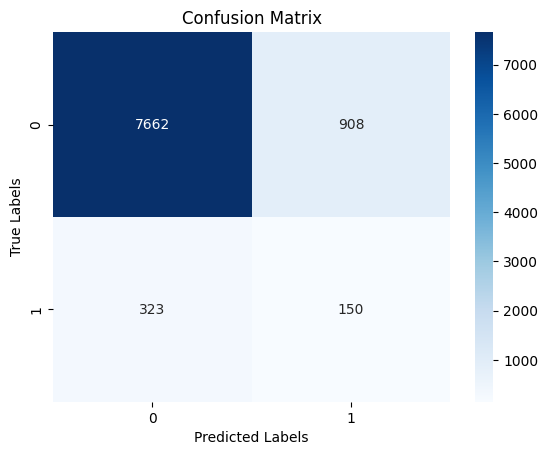

In [51]:
y_pred= best_rf.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7985
           1       0.32      0.14      0.20      1058

    accuracy                           0.86      9043
   macro avg       0.61      0.55      0.56      9043
weighted avg       0.83      0.86      0.84      9043



# The Best Performed Model

In [53]:
print(methods)
print(accu)

['Logistic Regression', 'KNN', 'Random Forest']
[0.7921043901360169, 0.8638726086475728, 0.8638726086475728]


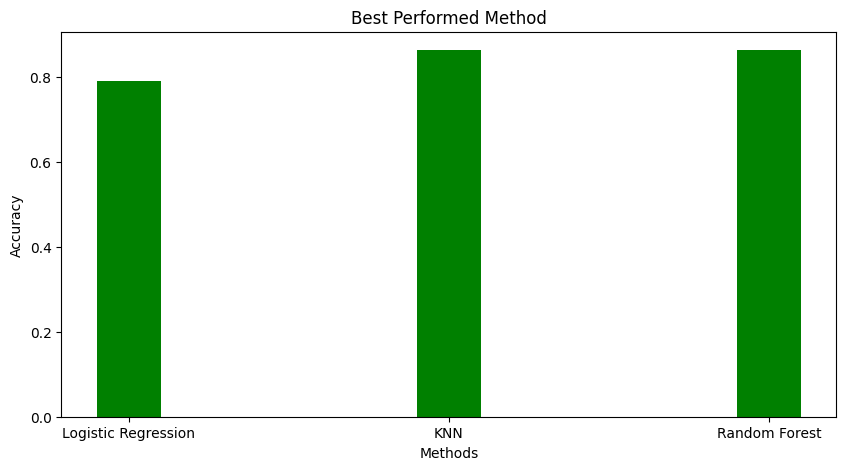

In [54]:
fig=plt.figure(figsize=(10,5))

#creating the bar plot
plt.bar(methods,accu,color='g',width=0.2)

plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Best Performed Method')
plt.show()

# Model Effectivness


### see ROC Curve (Receiver Operating Curve) & AUC

- The ROC curve tells us how well our classifier is classifying between term deposit suscriptions (True Positives) and non-term deposit suscriptions. 


- The X-axis is represented by False positive rates (Specificity) and the Y-axis is represented by the True Positive Rate (Sensitivity.) 


- As the line moves the threshold of the classification changes giving us different values. The closer is the line to our top left corner the better is our model separating both classes.

Text(0.5, 1.0, 'Area under ROC')

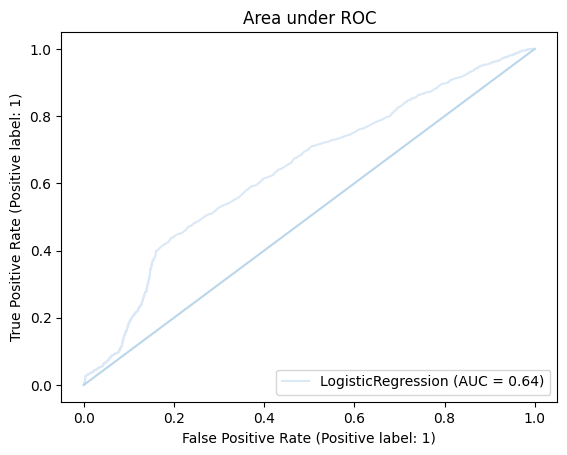

In [55]:
RocCurveDisplay.from_estimator(best_lr,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

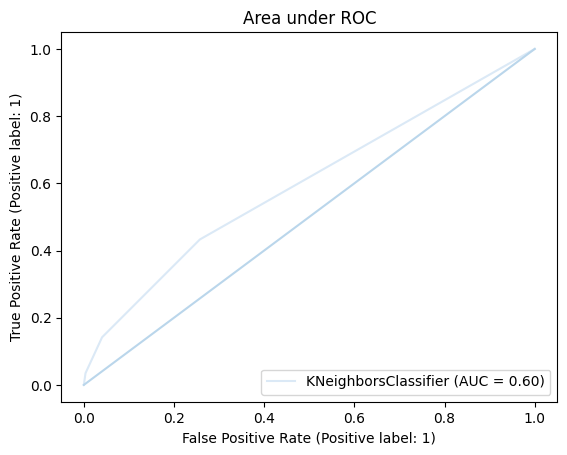

In [56]:
RocCurveDisplay.from_estimator(best_knn,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

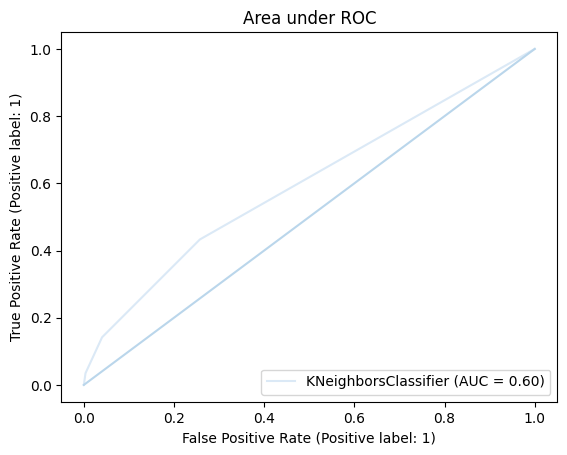

In [57]:
RocCurveDisplay.from_estimator(best_rf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

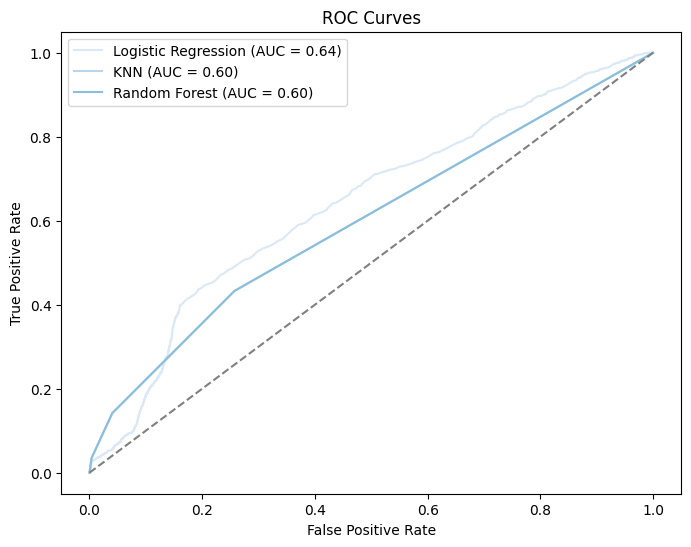

In [58]:
from sklearn.metrics import RocCurveDisplay

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for each model
RocCurveDisplay.from_estimator(best_lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(best_knn, X_test, y_test, ax=ax, name='KNN')
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, name='Random Forest')

# Plot the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add axis labels and a title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')

# Add a legend
ax.legend()


**Discussion on Evaluation** 


- The evaluation metrics used for this data are confusion matrix (recall_score, f1_score) and Receiver Operating Characteristics (ROC) curve. They were selected because:


1. The data are highly imbalance and skew towards the negative side of the company i.e., loss, so f1_score will help detect the harmonic mean between the sensitivity and specificity.



2. Higher recall score is better than higher precision here because recall score aka (sensitivity) is the fraction of retrieved instances among all relevant instances in our case, identifying the customers that will subscribe for a term deposit is much more important than identifying customers that may or may not subscribe.



3. ROC curve helps to explain how well each model explains the variance in the data closer to 1 is always preferred and should be above 0.5 to be better than random guess.












